In [8]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
# from bo_methods_lib.bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

In [9]:
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 2,
                 "param_name_str" : "a",
                 "retrain_GP": 5,
                 "num_x_data": 5,
                 "num_val_pts": 0}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [10]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
25,12,1,1585612.912573,1.0,0.0,"[-0.6274048388613718, -0.20070918286031647, -3...",-586160845.928586,2070586.273524,"[-0.7489732164629821, -2.0, -5.486214995235525...",2070586.273524,"[-0.7489732164629821, -2.0, -5.486214995235525...",0.263479,1,A1,2,0.526959,1.509500
30,0,0,14.276482,1.0,3.052607,"[-0.7518875176515021, -2.0, -5.929291481636396...",10.748305,23.565407,"[-2.0, -2.0, -2.220446049250313e-16, -2.0]",23.565407,"[-2.0, -2.0, -2.220446049250313e-16, -2.0]",0.475232,1,B1,3,1.425696,7.179136
137,1,29,14739.635804,1.0,367483.693662,"[-1.5249414797431173, -0.64645343352516, -6.76...",887.783125,935.153071,"[-1.5248081572739005, -0.8447617884110251, -6....",935.153071,"[-1.5248081572739005, -0.8447617884110251, -6....",329.844787,1,A2,36,11874.412336,0.555456
1084,14,8,14.276482,1.0,342.635558,"[-0.4077083808500539, 0.9511550772914474, -3.0...",10.144574,10.460133,"[-0.7936217690594068, -1.1283420780214681, -4....",10.460133,"[-0.7936217690594068, -1.1283420780214681, -4....",45.550071,1,B2,33,1503.152351,1.961218
1137,14,0,1585612.912573,1.0,0.0,"[-0.5376238501428094, -1.5420921394617464, -3....",58972.050669,1190320.897549,"[-0.07504339235716248, 1.0001027774818383, -9....",1190320.897549,"[-0.07504339235716248, 1.0001027774818383, -9....",41.026716,1,C2,2,82.053431,3.479919


In [11]:
def compare_muller_heat_map_hps(file_path, run_num, bo_iter, x_val_num, theta_choice, seed, gp_hp_alt, gen_meth_theta = Gen_meth_enum(1)):
    """
    Compares simulation and GP data for the Muller potential over a heat map
    
    Parameters
    ----------
    file_path: str, The file path of the data
    run_num: int, The run you want to analyze. Note, run_num 1 corresponds to index 0
    bo_iter: int, The BO iteration you want to analyze. Note, bo_iter 1 corresponds to index 0
    x_val_num: int, The number of x values to make heat maps over in each dimension of x data
    theta_choice: 1D ndarray, or None, the theta_value to evaluate the heat map at. If none, chosen based off seed
    seed: int, the seed for theta_choice if applicable
    
    Returns
    -------
    test_mesh: ndarray, meshgrid of x values to generate the heat map 
    y_sim: ndarray, The simulated values for test_mesh
    gp_mean: ndarray, The gp mean values for test_mesh
    gp_var: ndarray, The gp variance values for test_mesh
    theta_value: ndarray, the parameter set evaluated
    exp_data.x_vals: ndarray, experimental x data
    idcs_to_plot: list of str, all parameter names
    
    """
    run_num -= 1
    bo_iter -= 1
    loaded_results = open_file_helper(file_path)
    #get exp_data and theta_opt
    exp_data = loaded_results[run_num].exp_data_class
    gp_emulator = loaded_results[run_num].list_gp_emulator_class[bo_iter]
    #Change gp hps if applicable
    if gp_hp_alt is not None:
        gp_emulator.fit_gp_model.kernel_.k1.k2.length_scale = gp_hp_alt
        gp_emulator.fit_gp_model.kernel.k1.k2.length_scale = gp_emulator.fit_gp_model.kernel_.k1.k2.length_scale
    
    simulator = loaded_results[run_num].simulator_class
    sep_fact = loaded_results[run_num].configuration["Separation Factor"]
    method = GPBO_Methods(Method_name_enum(loaded_results[run_num].configuration["Method Name Enum Value"]))
    
    enum_ep = Ep_enum(loaded_results[run_num].configuration["Exploration Bias Method Value"])
    ep_at_iter = loaded_results[run_num].results_df["Exploration Bias"].iloc[bo_iter]
    ep_bias = Exploration_Bias(None, ep_at_iter, enum_ep, None, None, None, None, None, None, None)
    
    theta_true = loaded_results[run_num].simulator_class.theta_true
    theta_obj_min =  loaded_results[run_num].results_df["Theta Min Obj Cum."].iloc[bo_iter]
    theta_ei_max = loaded_results[run_num].results_df["Theta Max EI"].iloc[bo_iter]
    train_theta = loaded_results[run_num].list_gp_emulator_class[bo_iter].train_data.theta_vals
    
    if loaded_results[run_num].heat_map_data_dict is not None:
        param_names = list(loaded_results[run_num].heat_map_data_dict.keys())[0]
    else:
        cs_params, method, gen_meth_theta = get_driver_dependencies_from_results(loaded_results, run_num)
        driver = GPBO_Driver(cs_params, method, simulator, exp_data, gp_emulator.gp_sim_data, gp_emulator.gp_sim_data, gp_emulator.gp_val_data, gp_emulator.gp_val_data, gp_emulator, ep_bias, gen_meth_theta)
        loaded_results[run_num].heat_map_data_dict = driver.create_heat_map_param_data()
        param_names = list(loaded_results[run_num].heat_map_data_dict.keys())[0]
        
    idcs_to_plot = [loaded_results[run_num].simulator_class.theta_true_names.index(name) for name in param_names]
    idcs_to_plot = [loaded_results[run_num].simulator_class.theta_true_names.index(name) for name in param_names]
    
    #Generate simulation data for x given 1 theta
    simulator.seed = seed
    sim_data_x = simulator.gen_sim_data(1, x_val_num, Gen_meth_enum(1), Gen_meth_enum(2), sep_fact, False)
    if theta_choice is not None:
        sim_data_x.theta_vals[:] = theta_choice
        sim_data_x.y_vals = simulator.gen_y_data(sim_data_x, 0, 0)
    
    theta_value = sim_data_x.theta_vals[0]
    featurized_sim_x_data = gp_emulator.featurize_data(sim_data_x)
    sim_data_x.gp_mean, sim_data_x.gp_var = gp_emulator.eval_gp_mean_var_misc(sim_data_x, featurized_sim_x_data)
    
    #Create a meshgrid with x and y values fron the uniwue theta values of that array
    test_mesh = sim_data_x.x_vals.reshape(x_val_num, x_val_num,-1).T

    #Calculate valus
    y_sim = sim_data_x.y_vals.reshape(x_val_num, x_val_num).T
    gp_mean = sim_data_x.gp_mean.reshape(x_val_num, x_val_num).T
    gp_var = sim_data_x.gp_var.reshape(x_val_num, x_val_num).T
    
    if method.emulator == False and method.obj.value ==2:
        gp_mean = np.exp(sim_data_x.gp_mean.reshape(x_val_num, x_val_num).T)
        gp_var  =  np.exp(sim_data_x.gp_var.reshape(x_val_num, x_val_num).T)
    
    return test_mesh, y_sim, gp_mean, gp_var, theta_value, exp_data.x_vals, idcs_to_plot

Method:  C2
Run Number:  15
BO Iter Number:  1
Trained Hyperparameters:  [1.36113749e-01 2.21573761e+02 8.30968019e+02 1.67917241e+00
 3.00000000e-01 2.00000000e-01]


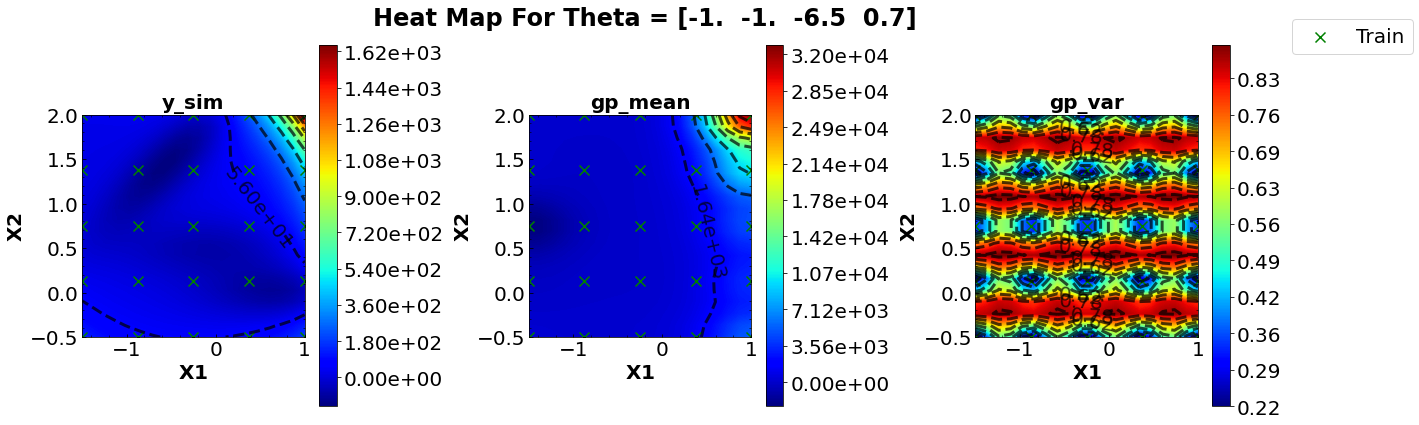

In [17]:
#Plot Muller potential for all methods
x_val_num = 20
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "jet"
plot_axis_names = ["X1", "X2"]
set_hps = True
verbose = True

meth_name_str_list = [3]
project = signac.get_project()

for meth_val in meth_name_str_list:
    #Get jobs corresponding to that method
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")
    
    #Open results, get the method, run, bo iter, and hyperparams
    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name
    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] + 1
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    
    #Set hyperparams
    if set_hps == False:
        gp_hp_alt = trained_hps
    elif meth_val < 3:
        gp_hp_alt = np.array([1.20177872, 9.74440209, 8.40406057, 2.04718705])
    else:
        gp_hp_alt = np.array([1.36113749e-01, 2.21573761e+02, 8.30968019e+02, 1.67917241e+00,
       3e-1, 2e-01])
        #np.array([1.36113749e-01, 2.21573761e+02, 8.30968019e+02, 1.67917241e+00,
       #9.62583264e-02, 2.31479009e-01])
    
    #Print values if verbose is true
    if verbose == True:
        print("Method: ", meth_name)
        print("Run Number: ", run_num)
        print("BO Iter Number: ", bo_iter)
        print("Trained Hyperparameters: ", gp_hp_alt)
    
    #Make muller potential at theta true
    theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true
    seed = loaded_results[0].configuration["Seed"]
   
    #Get heat map data
    if set_hps == False:
        data_vals = compare_muller_heat_map_hps(file_path, run_num, bo_iter, x_val_num, theta_choice, seed, None)
    else:
        data_vals = compare_muller_heat_map_hps(file_path, run_num, bo_iter, x_val_num, theta_choice, seed, gp_hp_alt)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    
    #Set plot details
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))
    z = [y_sim, gp_mean, gp_var]
    z_titles = ["y_sim", "gp_mean", "gp_var"]    
    levels = [100,100,100]
    
    plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
                   z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)